In [17]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

img_path = '../input/elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [18]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [94]:
curr_layer = "block5_conv3"
prev_layer = "block5_conv2"
model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer(prev_layer).output)

In [95]:
outp = model.predict(x)[0]
outp.shape

1/1 [==============================] - 2s 2s/step


(14, 14, 512)

In [96]:
w = base_model.get_layer(curr_layer).get_weights()
print([ wi.shape for wi in w ])
print(base_model.get_layer(curr_layer).strides)
print(base_model.get_layer(curr_layer).padding)

[(3, 3, 512, 512), (512,)]
(1, 1)
same


In [62]:
from scipy.linalg import svd, diagsvd
from einops import rearrange

def conv2d_weights_svd(w, verbose=False):

    w_shape = w.shape
    assert len(w_shape) == 4

    w = rearrange(w, "k_x k_y c_in c_out -> (k_x k_y c_in) c_out")
    u, s_array, vt = svd(w)
    s = diagsvd(s_array, *w.shape)

    if verbose:
        print(f"u.shape = {u.shape}. s.shape = {s.shape}. vt.shape = {vt.shape}.")

    return w, u, s, vt

In [97]:
w_matr, u, s, vt = conv2d_weights_svd(w[0], verbose=True)

u.shape = (4608, 4608). s.shape = (4608, 512). vt.shape = (512, 512).


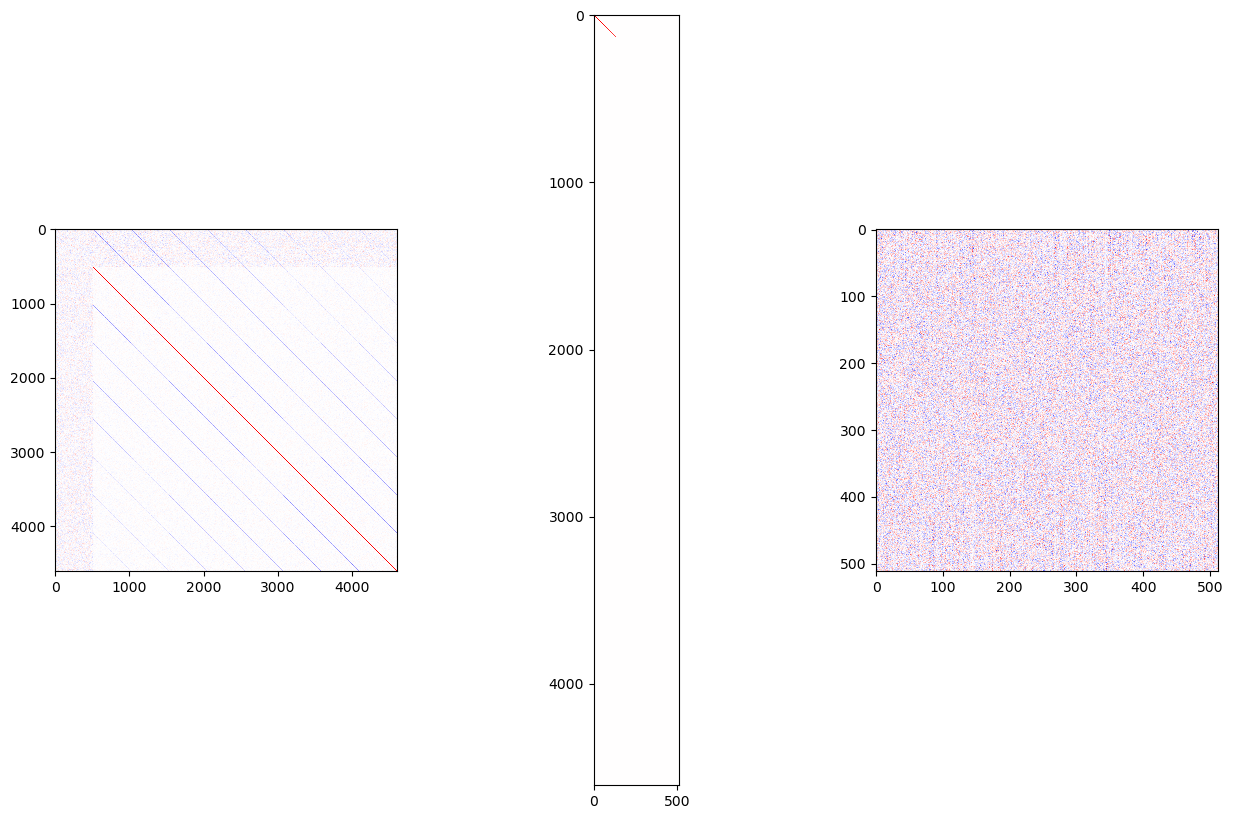

In [102]:
fig, axs = plt.subplots(1, 3, figsize=(15,10))
plot_matrix(u,  axs[0], scale=4)
plot_matrix(s,  axs[1], scale=4)
plot_matrix(vt, axs[2])

In [19]:
def plot_matrix(m, ax, scale=1.0, transpose=False):
    m = np.copy(m)
    mmax = np.max(np.abs(m)) / scale
    if transpose:
        m = m.T
    ax.imshow(m, cmap="bwr", vmin=-mmax, vmax=mmax, interpolation="nearest")
    ax.grid(False)

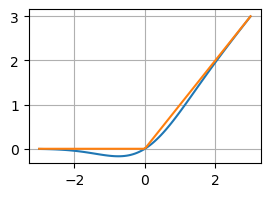

In [36]:
from scipy.special import erf

def gelu(x):
    return x / 2 * (1 + erf(x / np.sqrt(2)))

def relu(x):
    return np.maximum(x, 0)

fig, ax = plt.subplots(1,1,figsize=(3,2))
x_range = np.linspace(-3,3,100)
ax.plot(x_range, gelu(x_range));
ax.plot(x_range, relu(x_range));
ax.grid(True)

In [29]:
def transform_input(inp, kernel_size, strides):

    kernel_corners = np.arange(0, inp.shape[0] - kernel_size + 1, strides)
    dim_xy_out = len(kernel_corners)
    #print(kernel_corners, dim_xy_out)

    inp_transf = [ [ inp[y:y+kernel_size, x:x+kernel_size, :] for x in kernel_corners ] for y in kernel_corners ]

    inp_transf = np.array(inp_transf).reshape(dim_xy_out, dim_xy_out, -1)

    return inp_transf

In [90]:
transform_input(outp, 3, 1).shape

(26, 26, 4608)

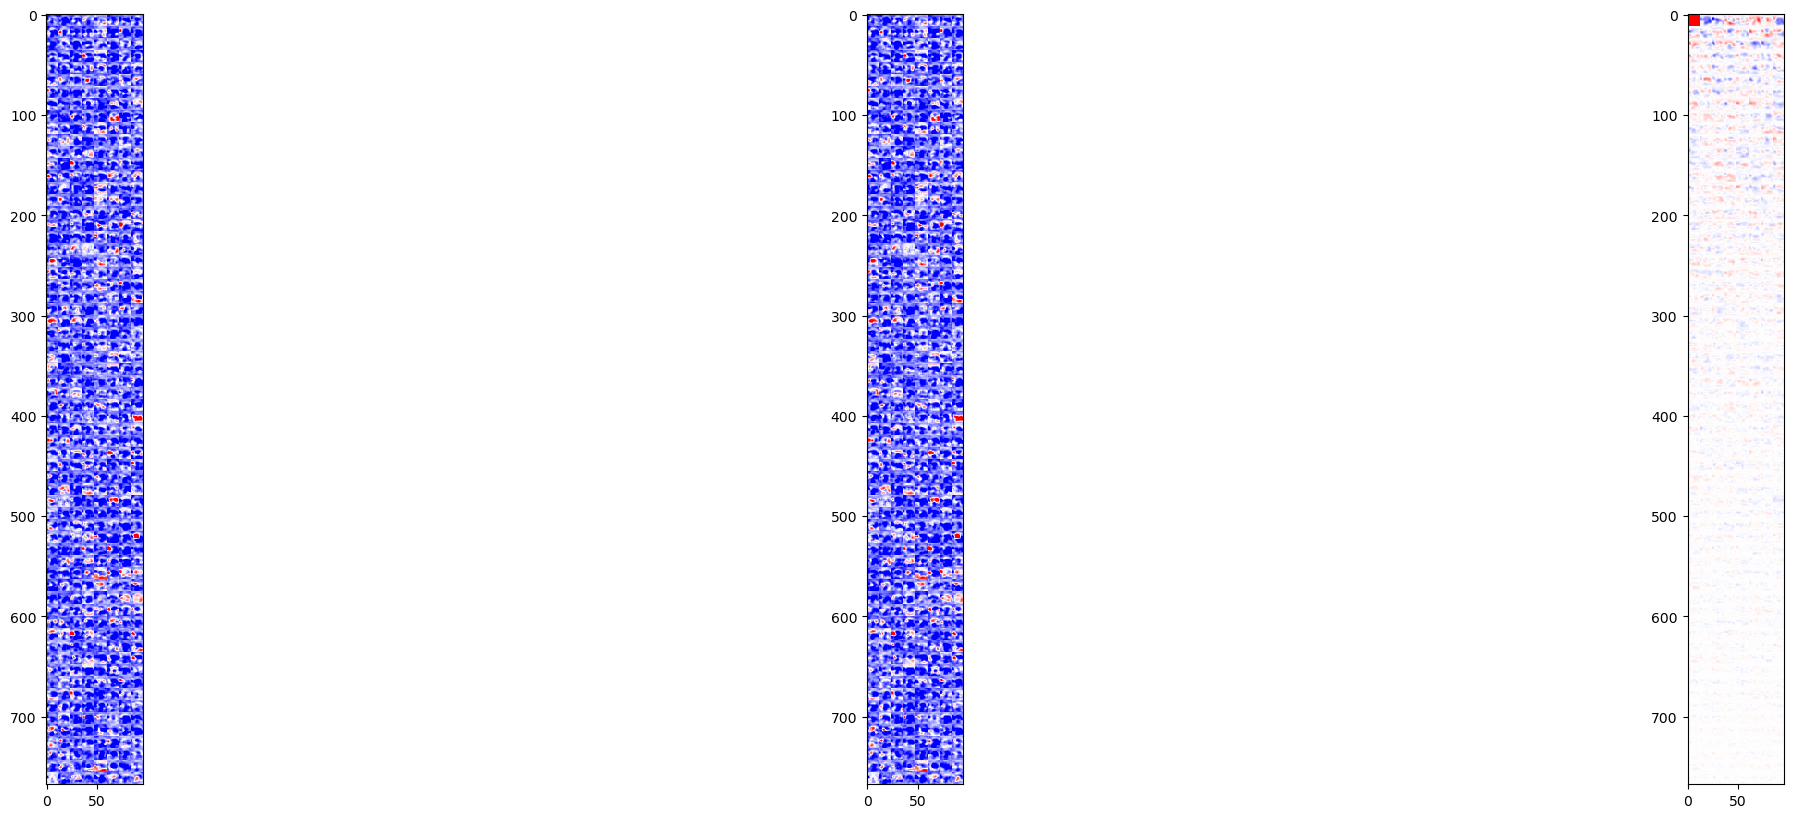

In [98]:
fig, axs = plt.subplots(1, 3, figsize=(30,10))

m0 = transform_input(outp, 3, 1)

m = m0 @ w_matr
m = rearrange(m, "h w (c1 c2) -> (c1 h) (c2 w)", c2=8)
plot_matrix(m, axs[0], scale=4)

m = m0 @ u @ s @ vt
m = rearrange(m, "h w (c1 c2) -> (c1 h) (c2 w)", c2=8)
plot_matrix(m, axs[1], scale=4)

m = m0 @ u @ s
m = rearrange(m, "h w (c1 c2) -> (c1 h) (c2 w)", c2=8)
plot_matrix(m, axs[2], scale=4)

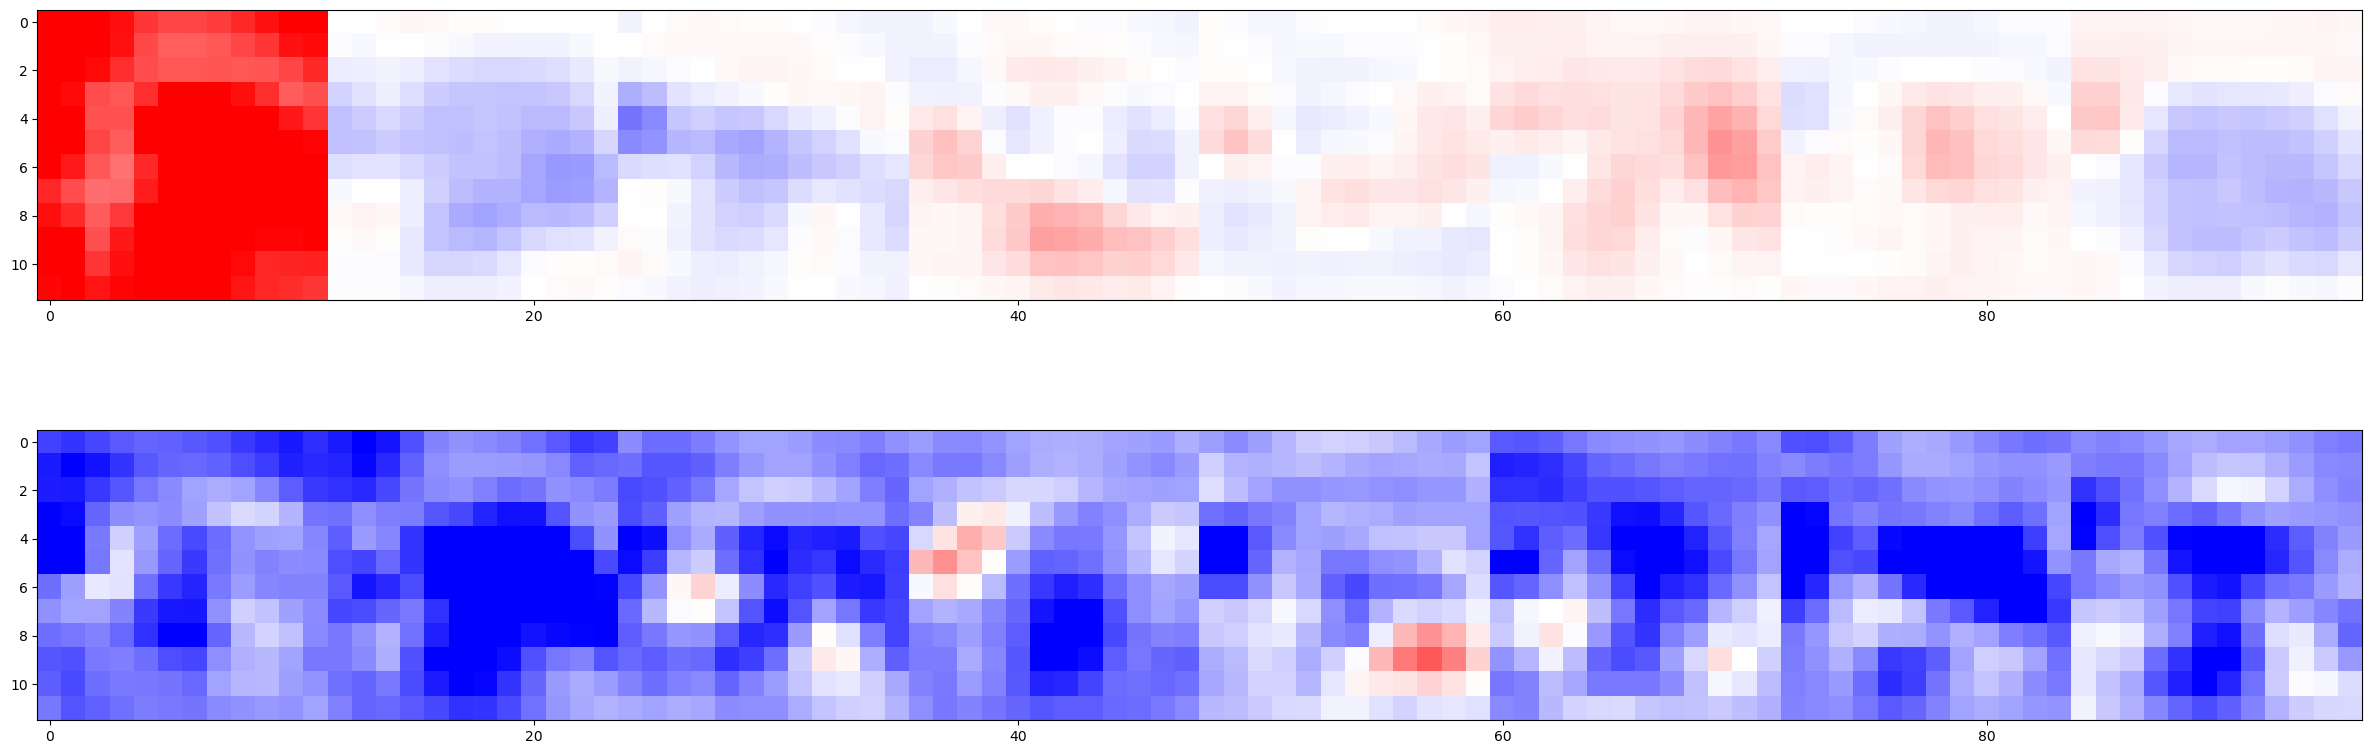

In [99]:
fig, axs = plt.subplots(2, 1, figsize=(30,10))

m = (m0 @ u @ s)[:,:,:8]
m = rearrange(m, "h w c -> h (c w)")
plot_matrix(m, axs[0], scale=2)

m = (m0 @ u @ s @ vt + w[1])[:,:,:8]
m = rearrange(m, "h w c -> h (c w)")
plot_matrix(m, axs[1], scale=2)


In [109]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     